In [207]:
import numpy as np
import csv
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as colors
COLORS = list(colors.CSS4_COLORS.keys())
import plotly.express as px
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import warnings
import scipy
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

%matplotlib notebook

In [2]:
def load_region(file):  
    df = pd.read_csv(file)
    df.index = df['timestamp']
    del df['timestamp']
    return df

In [3]:
DAYS = [31,28,31,30,31,30,31,31,30,31,30,31]
DAYS_SUM = [sum(DAYS[0:k]) for k in range(12)]

In [4]:
df = load_region('county1000.csv')

In [5]:
data = np.asarray(df[DAYS_SUM[4]*24*4:DAYS_SUM[7]*24*4]).astype('float16').T

In [164]:
data_days = data.reshape(blds,num_days,24*4)

In [6]:
blds, t_len = data.shape

<IPython.core.display.Javascript object>


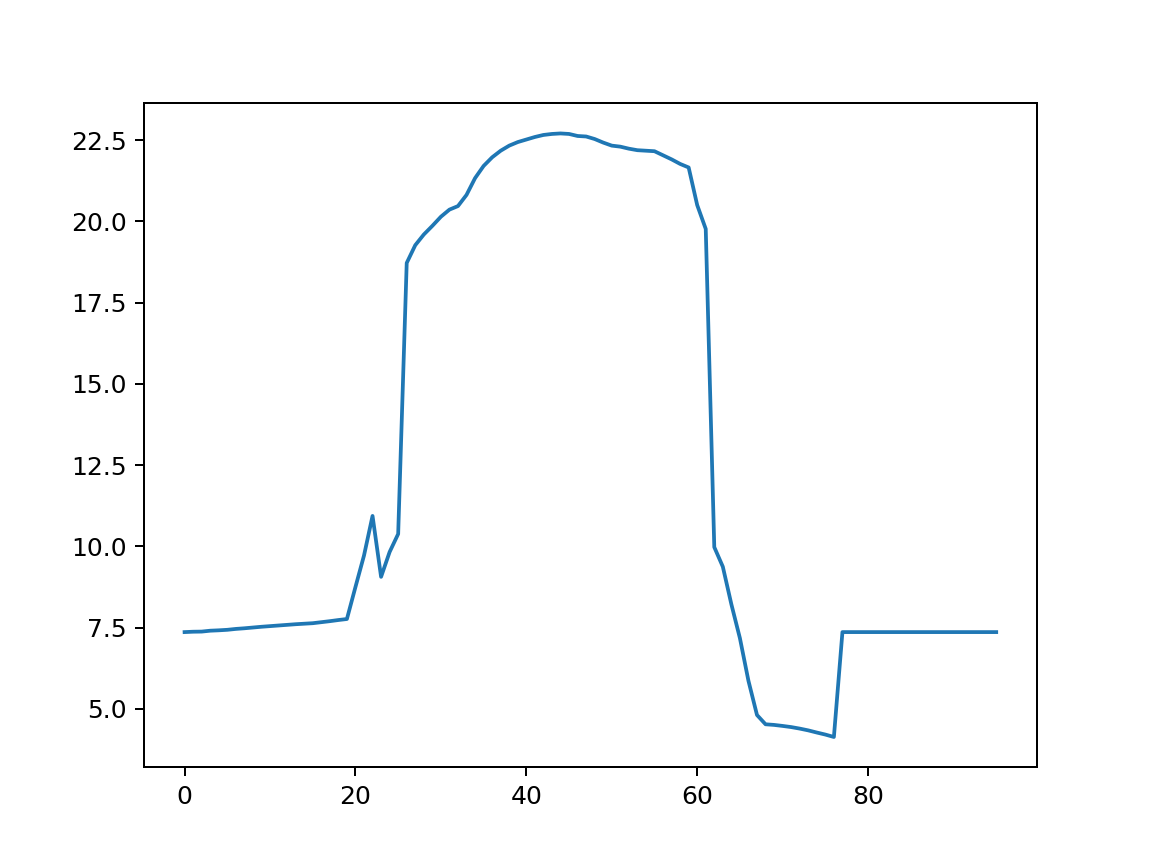

In [129]:
plt.plot(data_days[3,6,:])


In [160]:
n_peak = np.percentile(data,90,axis=1).reshape(blds,1)

In [161]:
n_base = np.percentile(data,10,axis=1).reshape(blds,1)

### peaks and bases per day

In [279]:
n_peak_d = np.percentile(data_days,95,axis=2,keepdims=True)
n_base_d = np.percentile(data_days,5,axis=2,keepdims=True)

7


<IPython.core.display.Javascript object>


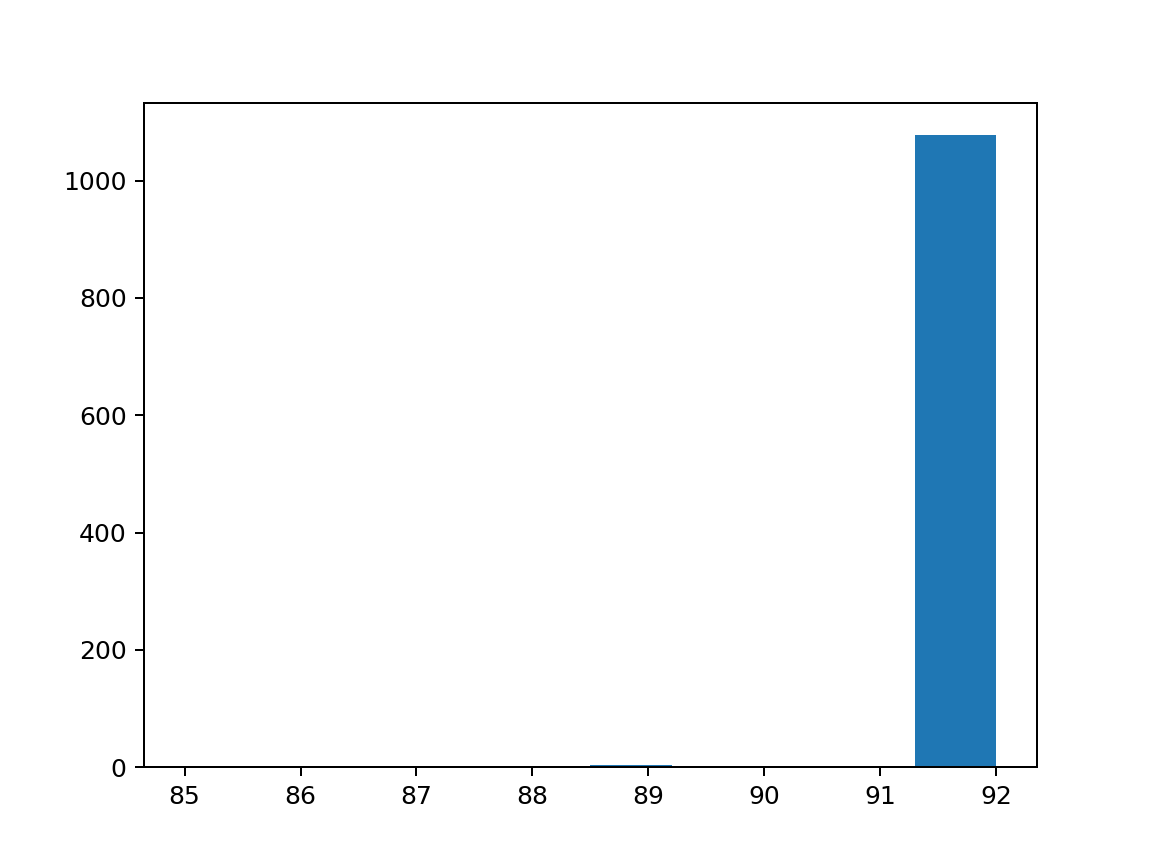

(array([1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 1.078e+03]),
 array([85. , 85.7, 86.4, 87.1, 87.8, 88.5, 89.2, 89.9, 90.6, 91.3, 92. ]),
 <BarContainer object of 10 artists>)

In [287]:
n_peak_d.shape,n_base_d.shape
working_days = np.sum((n_peak_d>n_base_d*1.2).astype(int),axis=1)
print(np.sum((working_days<92).astype(int)))
plt.hist(working_days)

In [192]:
high_load_dur = np.sum((data>.5*(n_peak+n_base)).astype(int) ,axis=1,keepdims=True)

In [163]:
num_days = t_len//(24*4)
num_days

92

In [165]:
rise_times = np.zeros(blds)
for b in range(blds):
    good_days=1
    all_rise = 0
    for d in range(num_days):
        above_peak = (data_days[b,d,:]>n_peak[b]).astype(int)
        below_base = (data_days[b,d,:]<n_base[b]).astype(int)
        if(np.sum(above_peak)>0):             
            above_ind = np.nonzero(above_peak)[0][0]
            mask = (np.arange(24*4)<above_ind).astype(int)
            if (np.sum(below_base*mask)>0):
                good_days+=1
                below_ind = np.nonzero(below_base*mask)[0][-1]
                all_rise += above_ind-below_ind
    rise_times[b] = all_rise/good_days
            

        

In [166]:
np.sum((rise_times==0).astype(int))

199

### the issue is that the low point occurs AFTER the peak in some buildings for every day in the data. Either I define two low points  OR I only use buildings without this issue

In [130]:
'''
make int bool where greater than peak
same for below base
np argwhere to get indices
first index of above peak
make mask such that any larger index is 0
last index of below base after mask
difference between indices
average over all days for building
IF there is no peak or base, act like day missing
'''    

'\nmake int bool where greater than peak\nsame for below base\nnp argwhere to get indices\nfirst index of above peak\nmake mask such that any larger index is 0\nlast index of below base after mask\ndifference between indices\naverage over all days for building\nIF there is no peak or base, act like day missing\n'

In [167]:
n_bases = np.zeros((blds,num_days,2))
n_bases[:,:,0] = np.percentile(data_days[:,:,:24*2],10,axis=2)
n_bases[:,:,1] = np.percentile(data_days[:,:,24*2:],10,axis=2)
n_bases_avg = np.mean(n_bases,axis=1)
n_bases_avg
# so now we have a 5th percentile for the first half and last half of the day, this might help

array([[25.18943614, 25.77117867],
       [ 6.88281675,  8.58914742],
       [ 3.06594769,  4.5978643 ],
       ...,
       [ 2.5460842 ,  5.05872537],
       [ 4.5863536 ,  7.58994141],
       [ 1.68123408,  1.75483345]])

In [195]:
rise_times = np.zeros((blds,1))
fall_times = np.zeros((blds,1))
for b in range(blds):
    good_days=1
    good_days_f=1
    all_rise = 0
    all_fall = 0
    for d in range(num_days):
        above_peak = (data_days[b,d,:]>n_peak[b]).astype(int)
        below_base = (data_days[b,d,:]<n_bases_avg[b,0]).astype(int)
        below_base_f = (data_days[b,d,:]<n_bases_avg[b,1]).astype(int)
        if(np.sum(above_peak)>0):             
            above_ind = np.nonzero(above_peak)[0][0]
            mask = (np.arange(24*4)<above_ind).astype(int)
            mask_f = (mask*-1)+1
            if (np.sum(below_base*mask)>0): #rise case
                good_days+=1
                below_ind = np.nonzero(below_base*mask)[0][-1]
                all_rise += above_ind-below_ind
            if (np.sum(below_base_f*mask_f)>0): # fall case
                good_days_f+=1
                fall_ind = np.nonzero(below_base_f*mask_f)[0][-1]
                all_fall += fall_ind-above_ind
    rise_times[b] = all_rise/good_days
    fall_times[b] = all_fall/good_days_f

        

In [196]:
print(blds -np.sum((rise_times==0).astype(int)),blds-np.sum((fall_times==0).astype(int)))
good_blds = (rise_times>0).astype(int)*(fall_times>0).astype(int)
np.sum(good_blds)

954 982


906

In [201]:
arg_blds = np.nonzero(good_blds)
good_data = data[arg_blds[0]]
good_data.shape

(906, 8832)

In [203]:
params = np.concatenate([
    n_peak,n_bases_avg,high_load_dur,
    rise_times,fall_times
    ],axis=1)[arg_blds[0]]

In [258]:
params_n =(params-np.mean(params,axis=0))/np.std(params,axis=0)

In [259]:
good_clust = {}

In [261]:
for i in np.random.randn(100)*4:
    eps = np.round(np.exp(i),6)
    
    clust = DBSCAN(eps=eps).fit(params_n)
    #print(np.round(eps,4),set(clust.labels_))
    if len(set(clust.labels_)) > 2:
        good_clust[eps]=clust

124.9277 {0}
1060.5143 {0}
0.0027 {-1}
9.7774 {0, -1}
9.1379 {0, -1}
15.2551 {0}
369.7132 {0}
0.1996 {0, 1, 2, 3, 4, 5, -1}
9.7982 {0, -1}
4.4653 {0, -1}
108.1968 {0}
1.5737 {0, -1}
0.1269 {0, -1}
14.6396 {0}
109.3692 {0}
1.1923 {0, -1}
0.0813 {-1}
67.2426 {0}
2098.8159 {0}
511.8133 {0}
1.0287 {0, -1}
0.0036 {-1}
0.2429 {0, 1, 2, 3, 4, 5, 6, 7, 8, -1}
0.1065 {-1}
0.5303 {0, 1, 2, 3, -1}
0.0105 {-1}
0.116 {-1}
1.7036 {0, -1}
18029.3389 {0}
10.866 {0, -1}
3.3444 {0, -1}
12.8633 {0}
27.5898 {0}
0.0305 {-1}
224.6089 {0}
2.6797 {0, 1, -1}
25.5362 {0}
0.0397 {-1}
99022.6217 {0}
0.0706 {-1}
15.6206 {0}
13.8781 {0}
0.0604 {-1}
0.0087 {-1}
1.6126 {0, -1}
13.3498 {0}
1.4429 {0, -1}
2.154 {0, -1}
0.2238 {0, 1, 2, 3, 4, 5, -1}
0.5595 {0, 1, -1}
0.0003 {-1}
0.8994 {0, -1}
20.7212 {0}
6.1966 {0, -1}
0.7184 {0, 1, -1}
0.131 {0, -1}
0.8136 {0, -1}
0.7684 {0, -1}
82.2332 {0}
0.2559 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, -1}
0.0327 {-1}
16.4869 {0}
217.7503 {0}
143.1545 {0}
9.6617 {0, -1}
5.

In [262]:
good_clust.keys()

dict_keys([0.399827, 0.46461, 0.198177, 0.218332, 0.32248, 0.214186, 0.380682, 0.20944, 0.276135, 0.462419, 0.164843, 0.155032, 0.493072, 0.199552, 0.242879, 0.530335, 2.679748, 0.223803, 0.559509, 0.718421, 0.255886, 0.396818, 0.157497, 0.701692, 0.499274, 0.526405, 0.467963, 1.219926, 0.729, 1.255661])

In [270]:
eps_dbis = np.zeros((len(good_clust.keys()),2))
count = 0
for k in good_clust.keys():
    eps_dbis[count,1] = davies_bouldin_score(params_n, good_clust[k].labels_)
    eps_dbis[count,0] = k
    count+=1
eps_dbis

array([[0.399827  , 1.57858213],
       [0.46461   , 2.97807213],
       [0.198177  , 1.4210288 ],
       [0.218332  , 1.46852959],
       [0.32248   , 2.28467892],
       [0.214186  , 1.34776711],
       [0.380682  , 1.63446825],
       [0.20944   , 1.34184734],
       [0.276135  , 1.93838454],
       [0.462419  , 2.88635023],
       [0.164843  , 1.00612671],
       [0.155032  , 1.00630536],
       [0.493072  , 1.92658049],
       [0.199552  , 1.4210288 ],
       [0.242879  , 2.05393751],
       [0.530335  , 1.90115483],
       [2.679748  , 1.54867532],
       [0.223803  , 1.45326183],
       [0.559509  , 2.24515298],
       [0.718421  , 1.63749402],
       [0.255886  , 1.89852587],
       [0.396818  , 1.54558188],
       [0.157497  , 1.01103832],
       [0.701692  , 1.92451554],
       [0.499274  , 1.9300471 ],
       [0.526405  , 1.90037317],
       [0.467963  , 2.81008308],
       [1.219926  , 2.6167629 ],
       [0.729     , 1.63587318],
       [1.255661  , 2.6167629 ]])

<IPython.core.display.Javascript object>


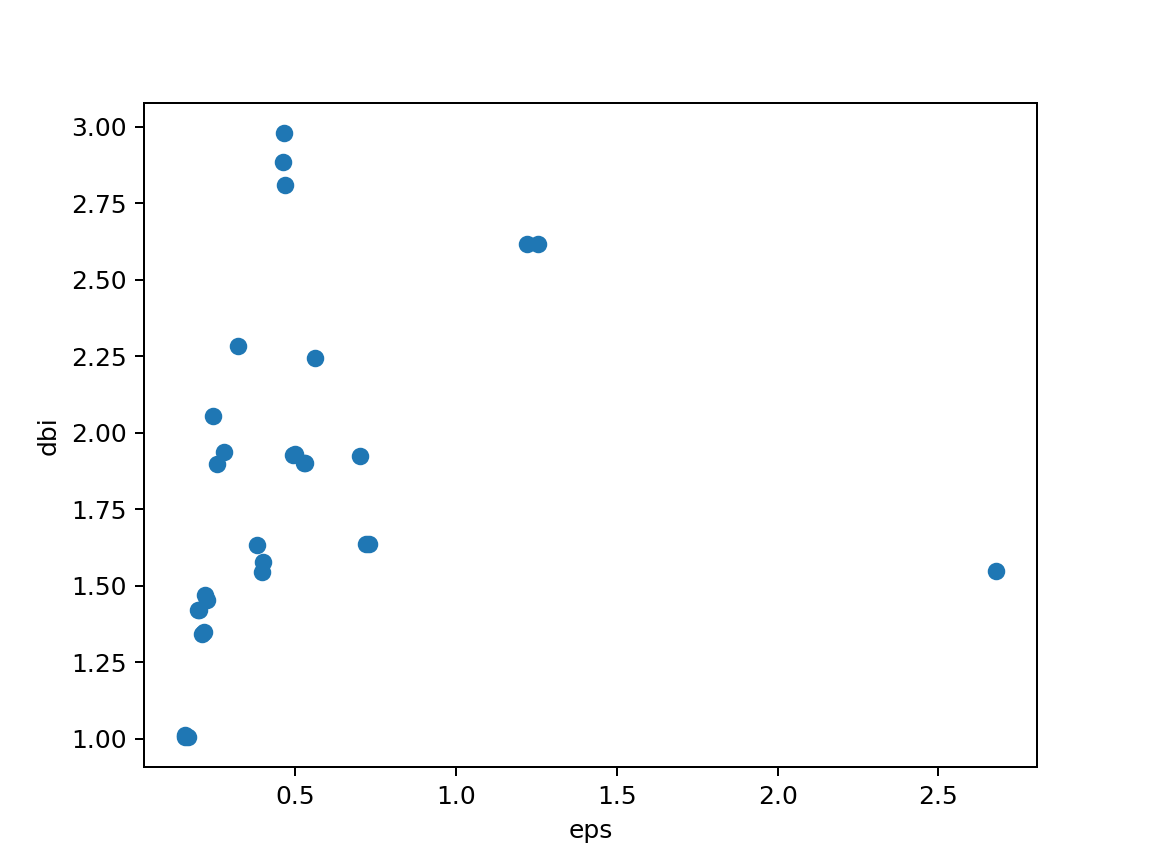

Text(0, 0.5, 'dbi')

In [275]:
plt.scatter(eps_dbis[:,0],eps_dbis[:,1])
plt.xlabel('eps')
plt.ylabel('dbi')

## kmeans


In [296]:
k_dbi = np.zeros(498)
for i in np.arange(2,500):
    clust = KMeans(n_clusters=i,random_state=0).fit(params_n)
    k_dbi[i-2] =  davies_bouldin_score(params_n, clust.labels_)
    

<IPython.core.display.Javascript object>


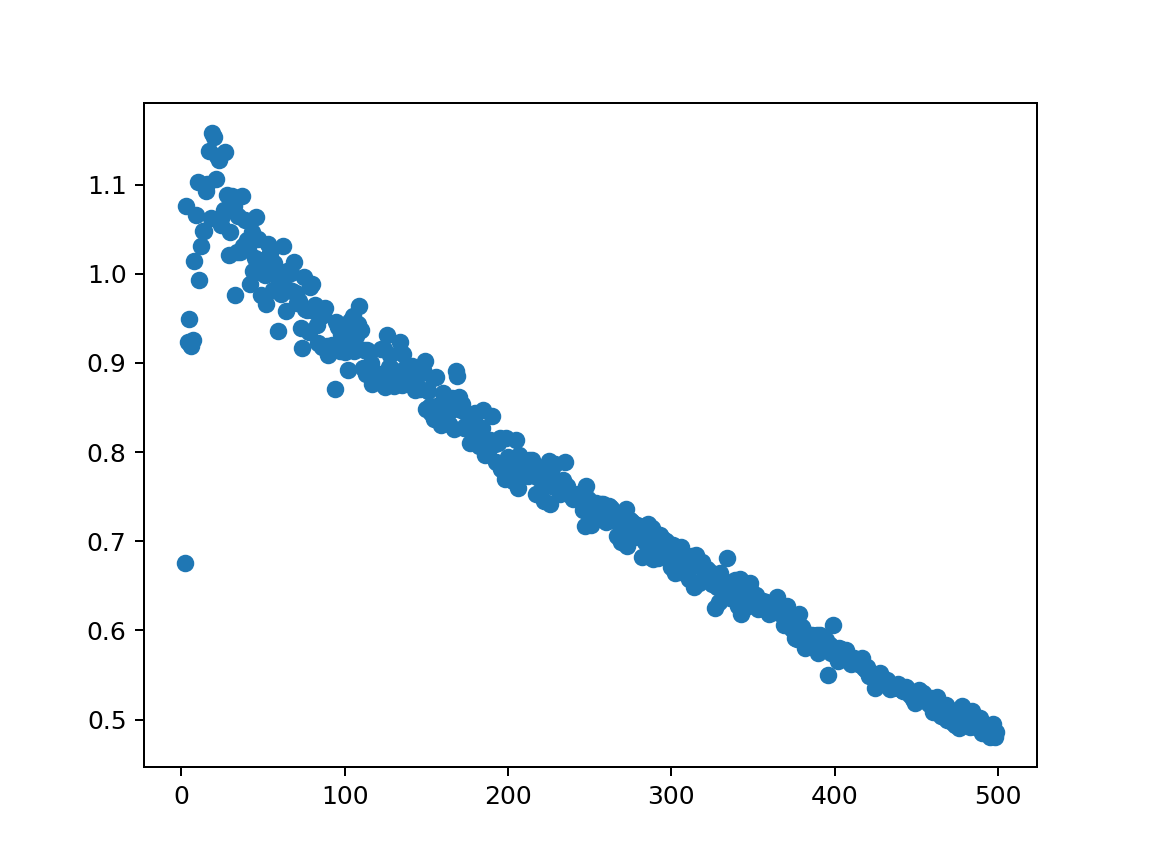

In [297]:
plt.scatter(np.arange(2,500),k_dbi)

In [266]:
KMeans?

In [255]:
set(good_clust[1.28072].labels_)

{-1, 0, 1}

In [256]:
set(good_clust[0.162233].labels_)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [5]:
tr = get_top_month(df)

In [6]:
trM = np.asarray(tr,dtype='float16').T

In [7]:
def plotem(labels, M, axes = ['std','tmax','max'] ):
    COLORS = ['r','g','b','y','m','k','c']
    #labels as provided by the labels_ from DBSCAN
    #M a tall matrix where each row is a coordinate triple
    #can handle up to seven clusters with the colors
    groups = {}
    fig = plt.figure(figsize = (5, 5))
    ax = plt.axes(projection ="3d")
    for k in range(len(set(labels))):
        i = list(set(labels))[k]
        groups[i] = np.array([M[j] for j in range(M.shape[0]) if labels[j]==i],dtype='float16')
        ax.scatter3D(groups[i][:,0],groups[i][:,1],groups[i][:,2],
                     color = COLORS[i%len(COLORS)])
    ax.set_xlabel(axes[0])
    ax.set_ylabel(axes[1])
    ax.set_zlabel(axes[2])
    ax.set_title(str(len(set(labels)))+' clusters' )
    plt.show()

In [8]:
def plotem2D(labels, M, axes = ['max','tmax'],COLORS =COLORS):
    numColors = len(COLORS)
    #labels as provided by the labels_ from DBSCAN
    #M a tall matrix where each row is a coordinate triple
    #can handle up to seven clusters with the colors
    groups = {}
    labels = (labels).astype(int)
    plt.figure(figsize = (7, 7))
    numLabels = len(set(labels))
    leg =[]
    for k in range(numLabels):
        i = list(set(labels))[k]
        groups[i] = np.array([M[j] for j in range(M.shape[0]) if labels[j]==i],dtype='float16')
        leg+=[str(k)]
        plt.scatter(groups[i][:,0],groups[i][:,1],
                     color = COLORS[-2 -numColors//numLabels*k])
    plt.legend(leg)
    plt.xlabel(axes[0])
    plt.ylabel(axes[1])
    plt.title(str(len(set(labels)))+' clusters' )
    plt.show()

In [9]:
%matplotlib inline

In [10]:
COLORS = list(colors.CSS4_COLORS.keys())

In [11]:
blds = trM.shape[0]

In [12]:
maxs =np.reshape(np.max(trM,axis=1),(blds,1))
tmax = np.reshape(np.argmax(trM,axis=1)%96,(blds,1))
maxStats=np.concatenate([maxs,tmax],axis=1)
print(maxStats.shape,np.std(maxStats,axis=0))
maxStats3 = maxStats/np.std(maxStats,axis=0)
np.save('maxStats3',maxStats)

(268, 2) [ 1.34071381 17.08092194]


In [13]:
def cluster_sizes(arr):
    for i in list(set(arr)):
        print(i,'has ',np.sum(arr==i),'elements')

## Clustering on tmax and max, scaled by std

### kmeans


with  8 clusters
0 has  29 elements
1 has  48 elements
2 has  23 elements
3 has  9 elements
4 has  82 elements
5 has  8 elements
6 has  62 elements
7 has  7 elements


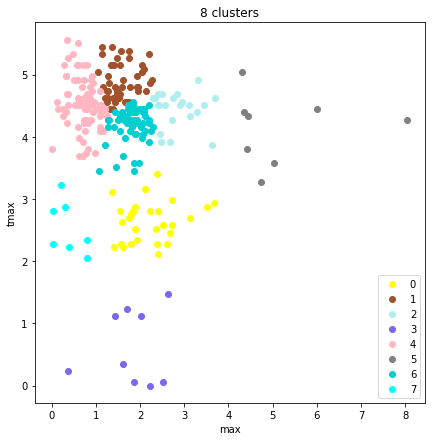

In [14]:
for n in range(8,9):
    kmeans = KMeans(n_clusters=n, random_state=0).fit(maxStats3)
    print('\nwith ',n, 'clusters')
    cluster_sizes(kmeans.labels_)
    plotem2D(kmeans.labels_,maxStats3)

In [15]:
kmeans8 = KMeans(n_clusters=8, random_state=0).fit(maxStats3)
kmeans9 = KMeans(n_clusters=9, random_state=0).fit(maxStats3)
kmeans10 = KMeans(n_clusters=10, random_state=0).fit(maxStats3)


In [16]:
np.save('maxStd8_clust',kmeans8.labels_)
np.save('maxStd9_clust',kmeans9.labels_)
np.save('maxStd10_clust',kmeans10.labels_)

## what about letting tmax be something else, like the time of day that most often has the maximum? time of day for monthly maximum seems like a lot

In [17]:
dailyM = np.reshape(trM,(blds,30,96))

In [18]:
modeObj = scipy.stats.mode(((np.argmax(dailyM,axis=2))//4)*4,axis=1)

In [19]:
modes = modeObj[0].astype('int16')

In [20]:
modes.shape

(268, 1)

(array([ 4., 10., 16., 27., 19., 21., 25., 18., 20.,  0., 18., 18.,  5.,
         7., 10.,  9.,  3.,  6.,  3.,  0.,  5.,  5.,  2.,  2.,  4.,  2.,
         1.,  2.,  2.,  4.]),
 array([ 3. ,  3.9,  4.8,  5.7,  6.6,  7.5,  8.4,  9.3, 10.2, 11.1, 12. ,
        12.9, 13.8, 14.7, 15.6, 16.5, 17.4, 18.3, 19.2, 20.1, 21. , 21.9,
        22.8, 23.7, 24.6, 25.5, 26.4, 27.3, 28.2, 29.1, 30. ]),
 <BarContainer object of 30 artists>)

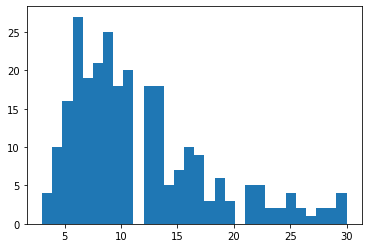

In [31]:
plt.hist(modeObj[1],bins=30)

In [22]:
avgMax = np.reshape(np.max(np.mean(dailyM,axis=1),axis= 1),(blds,1)).astype('float16')

In [23]:
stats4 = np.concatenate([avgMax,modes],axis=1)
np.save('stats4',stats4)

In [24]:
stats4n = stats4/np.std(stats4,axis=0)


with  8 clusters
0 has  79 elements
1 has  29 elements
2 has  7 elements
3 has  83 elements
4 has  2 elements
5 has  40 elements
6 has  14 elements
7 has  14 elements


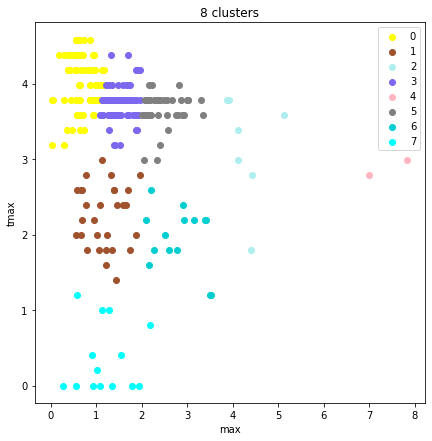

In [25]:
for n in range(8,9):
    kmeans = KMeans(n_clusters=n, random_state=0).fit(stats4n)
    print('\nwith ',n, 'clusters')
    cluster_sizes(kmeans.labels_)
    plotem2D(kmeans.labels_,stats4n)

In [26]:
kmeans8 = KMeans(n_clusters=8, random_state=0).fit(stats4n)

In [27]:
np.save('robustMax_clust',kmeans8.labels_)